# Advanced Lane Finding Project

## The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---



# Step 1:

## Compute the camera calibration using chessboard images

#### Map the coordinates of the corners in the above 2D image, which I will call it as Image points to the 3D       coordinates of the real undistored chessboard corners, which I will call it as Object points.

#### So, setup two empty arrays to hold these points.

#### The object points will all be the same, Just the known object coordinates of the chessboard corners for an 9x6  board.

#### (0,0,0) from top left to (8,5,0) to the bottom right.  The "z" coorindate will be 0 at every point, since the board is on a flat Image plane.

#### So, prepare these object points first by creating 6x9 points in an array, each with 3 columns x,y,z of each corner and initialize these with 0 using numpy function.

#### For the first 2 columns x and y, use numpy's Mgrid function to generate the coordinates that we need.  Mgrid returns the values of the coordinates, and we will shape those coordinates into two colulmns one for x and one for y.

## Import all the required modules

In [1]:
import cv2
import numpy as np
import glob
import os
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

In [3]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        print("Working on ", fname)
        objpoints.append(objp)
        imgpoints.append(corners)
     
        # Draw the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = './output_images/corners_found' +str(i)+'.jpg'
        cv2.imwrite(write_name, img)
        

Working on  ./camera_cal/calibration6.jpg
Working on  ./camera_cal/calibration7.jpg
Working on  ./camera_cal/calibration3.jpg
Working on  ./camera_cal/calibration2.jpg
Working on  ./camera_cal/calibration20.jpg
Working on  ./camera_cal/calibration19.jpg
Working on  ./camera_cal/calibration18.jpg
Working on  ./camera_cal/calibration15.jpg
Working on  ./camera_cal/calibration14.jpg
Working on  ./camera_cal/calibration16.jpg
Working on  ./camera_cal/calibration17.jpg
Working on  ./camera_cal/calibration13.jpg
Working on  ./camera_cal/calibration12.jpg
Working on  ./camera_cal/calibration10.jpg
Working on  ./camera_cal/calibration11.jpg
Working on  ./camera_cal/calibration9.jpg
Working on  ./camera_cal/calibration8.jpg


Text(0.5,1,'Undistorted Image')

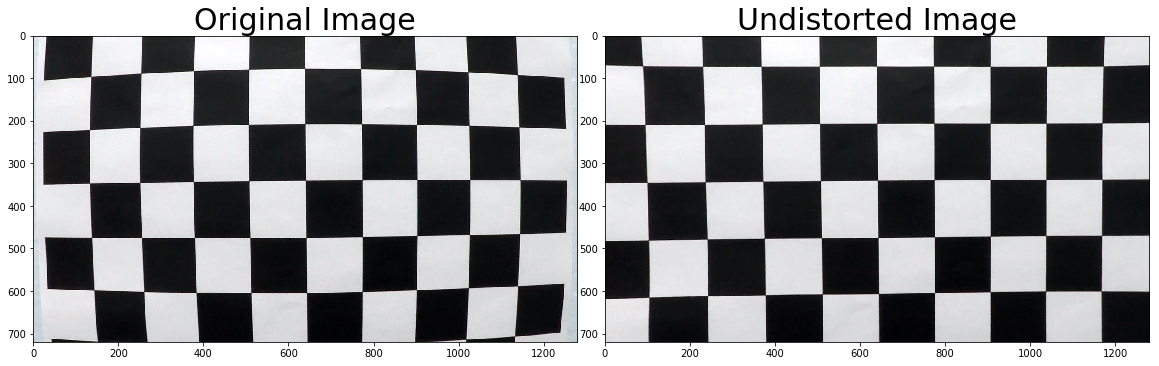

In [4]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_calibration.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


## Apply the generated distortion coefficients to all the test Images to undistort them.

In [5]:
# undistort image using camera calibration matrix from above
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

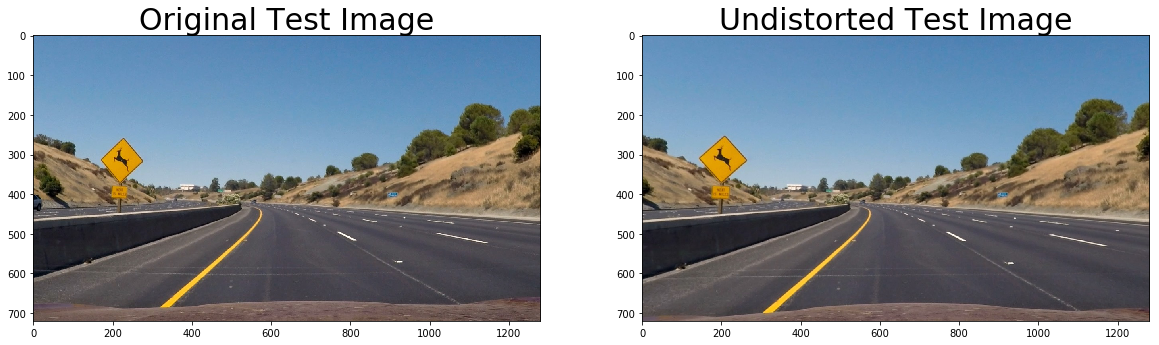

In [6]:
# Read all the test Images and apply the undistortion.
testImages = glob.glob('./test_images/test*.jpg')

for i, fname in enumerate(testImages):
    testImg = cv2.imread(fname)
    testImg = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)
    undist_img = undistort(testImg)
    undist_img = cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB)
    write_name = './output_images/undist_test_image'+str(i)+'.jpg'
    cv2.imwrite(write_name, undist_img )


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Original Test Image', fontsize=30)
ax1.imshow(testImg)

ax2.set_title('Undistorted Test Image', fontsize=30)
undist_img = cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB)
ax2.imshow(undist_img)

# Step 2

# Perspective Transformation

## Object appears smaller the farther away from a view point from a camera, and a parallel lines seem to converge to a point.

### Apply the Perspective Transform to get the Bird's Eye view lane.

### A perspective transform maps the points in a given image to different, desired, image points with a new perspective. 

### The most interested perspective transform is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. 


In [7]:
def warp(img, src, dst):
    
    # Define calibration box in source and destination coordinates
    h,w = img.shape[:2]
    
    #Compute the perspective transform:
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv


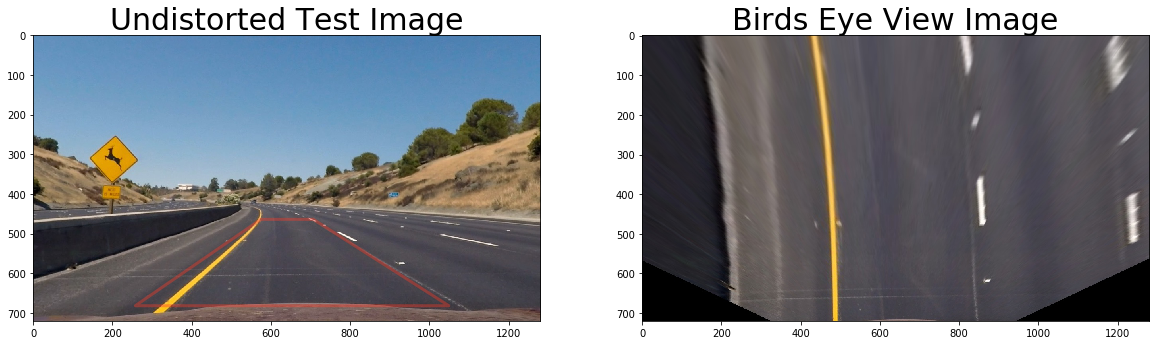

In [8]:
h,w = undist_img.shape[:2]

# define source and destination points for transform
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

undist_Images = glob.glob('./output_images/undist*.jpg')

for i, fname in enumerate(undist_Images):
    undist_testImg = cv2.imread(fname)
    undist_testImg = cv2.cvtColor(undist_testImg, cv2.COLOR_BGR2RGB)
    warp_img, M, Minv = warp(undist_testImg, src, dst)
    warp_img = cv2.cvtColor(warp_img, cv2.COLOR_BGR2RGB)
    write_name = './output_images/warped_image'+str(i)+'.jpg'
    cv2.imwrite(write_name, warp_img )



# Visualize Undistorted Warped 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#FA3B29', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])

ax1.set_title('Undistorted Test Image', fontsize=30)
undist_testImg = cv2.imread('./output_images/undist_test_image5.jpg')
undist_testImg = cv2.cvtColor(undist_testImg, cv2.COLOR_BGR2RGB)
ax1.imshow(undist_testImg)

ax2.set_title('Bird''s Eye View Image', fontsize=30)
warp_img = cv2.imread('./output_images/warped_image1.jpg')
warp_img = cv2.cvtColor(warp_img, cv2.COLOR_BGR2RGB)
ax2.imshow(warp_img)

# Sobel Operator

### The Sobel operator is at the heart of the Canny edge detection algorithm.  Applying the Sobel operator to an image is a way of taking the derivative of the image in the x or y direction.

In [9]:
def abs_sobel_threshold(img, orient='x', threshold=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1,0)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0,1)
    
    # Calculate the absolute value of the x and y derivatives:
    if orient == 'x':
        abs_sobel = np.absolute(sobel_x)
    if orient == 'y':
        abs_sobel = np.absolute(sobel_y)
    
    # Convert the absolute value image to 8-bit:
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a binary threshold to select pixels based on gradient strength
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
    
    return binary_output

# Magnitude of the Gradient

## Apply a threshold to the overall magnitude of the gradient, in both x and y.

In [10]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=21, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


# Direction of the Gradient

## The direction of the gradient is simply the inverse tangent (arctangent) of the y gradient divided by the x gradient

In [11]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=21, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


# Display Sobel output

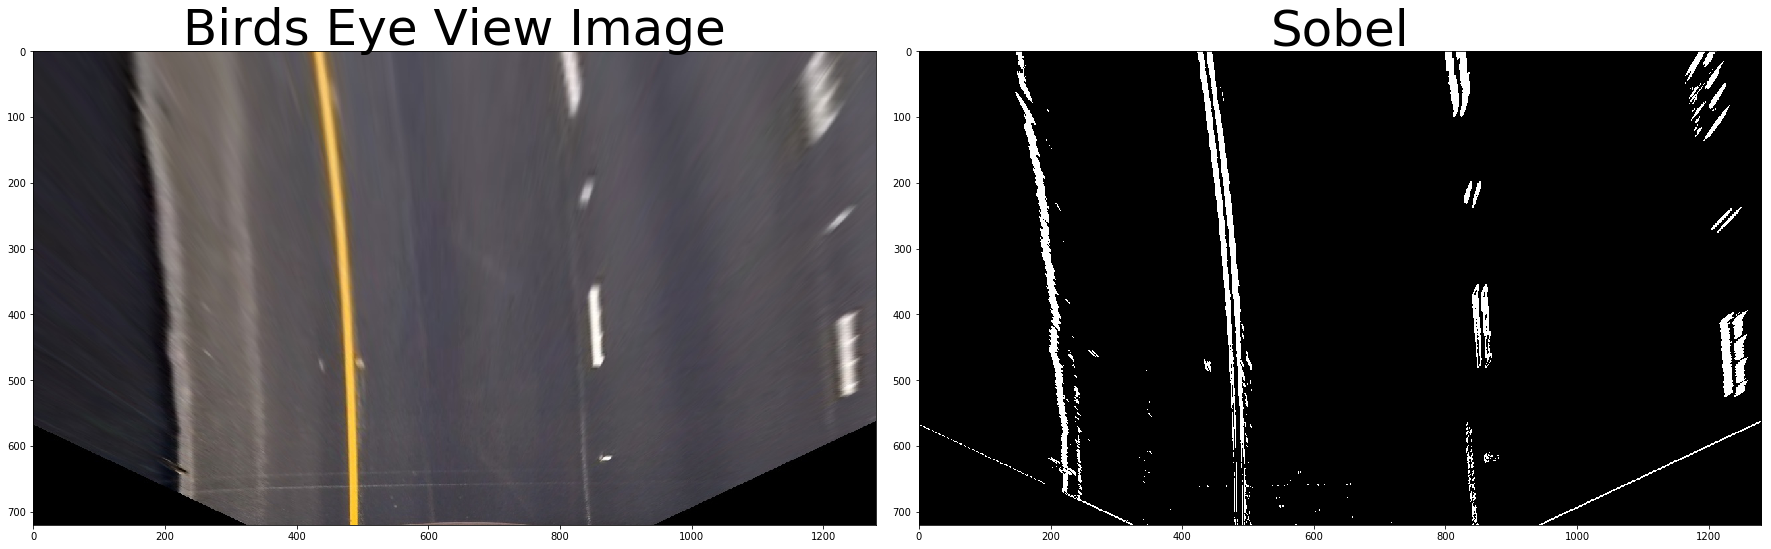

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

undist_warpImg = cv2.imread('./output_images/warped_image1.jpg')
undist_warpImg = cv2.cvtColor(undist_warpImg, cv2.COLOR_BGR2RGB)
ax1.imshow(undist_warpImg)
ax1.set_title('Bird''s Eye View Image', fontsize=50)

grad_binary = abs_sobel_threshold(undist_warpImg, orient='x', threshold=(20,100))
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Sobel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Display Magnitude Gradient output

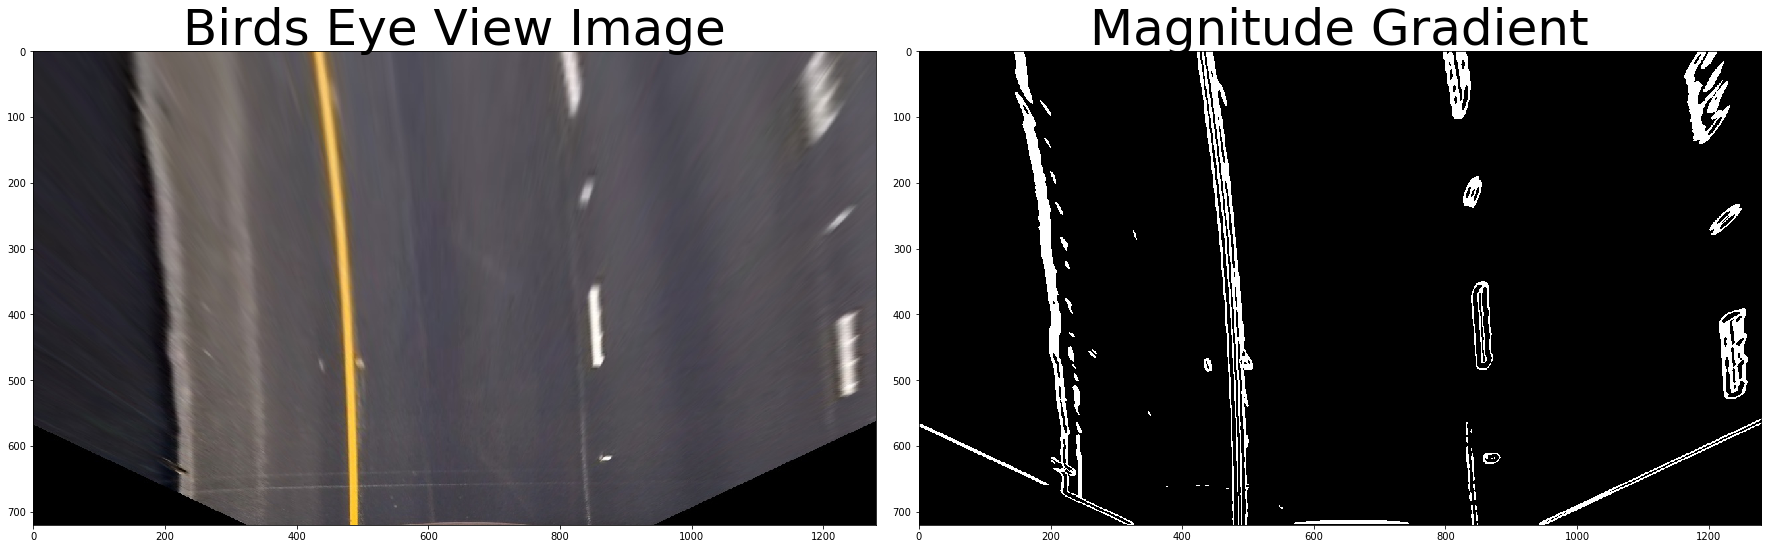

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

undist_warpImg = cv2.imread('./output_images/warped_image1.jpg')
undist_warpImg = cv2.cvtColor(undist_warpImg, cv2.COLOR_BGR2RGB)
ax1.imshow(undist_warpImg)
ax1.set_title('Bird''s Eye View Image', fontsize=50)

mag_binary = mag_thresh(undist_warpImg, sobel_kernel=21, mag_thresh=(30, 100))
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Magnitude Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Display Direction of Threshold output

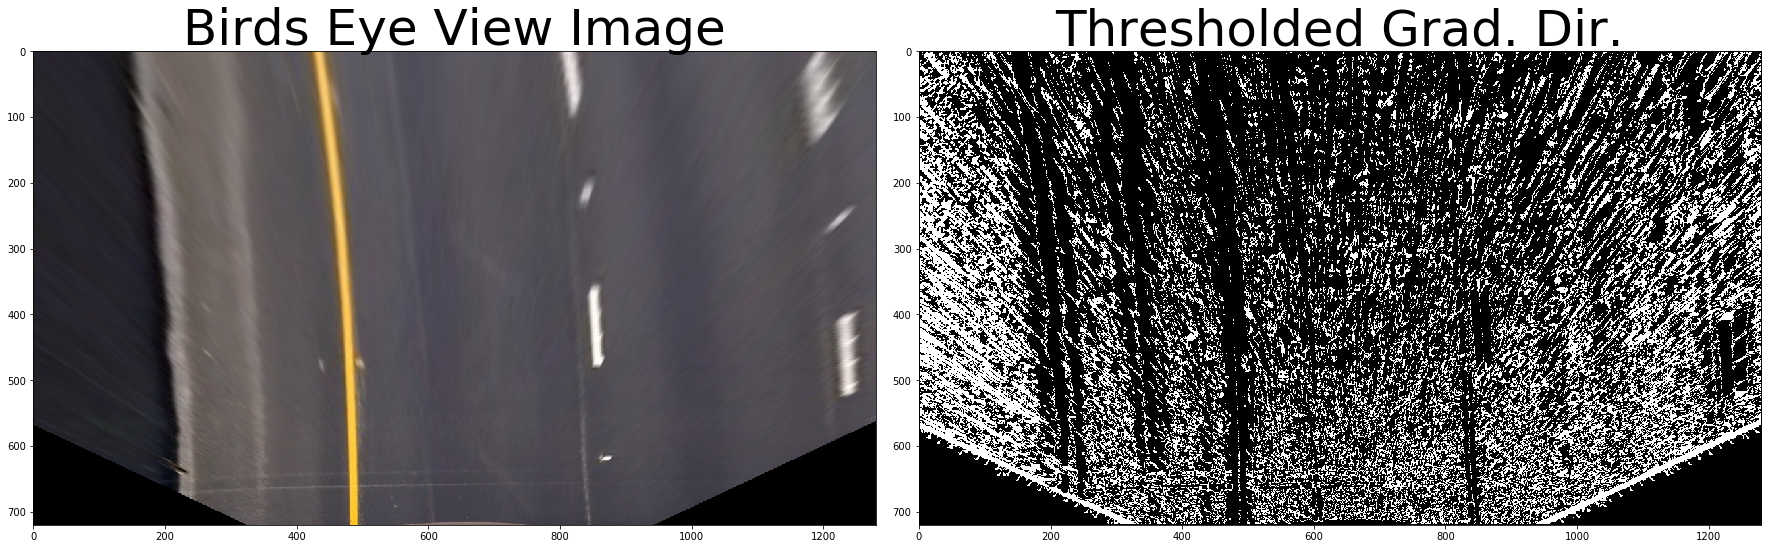

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

undist_warpImg = cv2.imread('./output_images/warped_image1.jpg')
undist_warpImg = cv2.cvtColor(undist_warpImg, cv2.COLOR_BGR2RGB)
ax1.imshow(undist_warpImg)
ax1.set_title('Bird''s Eye View Image', fontsize=50)

dir_binary = dir_threshold(undist_warpImg, sobel_kernel=11, thresh=(0.7, 1.3))
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Combining Thresholds and Display


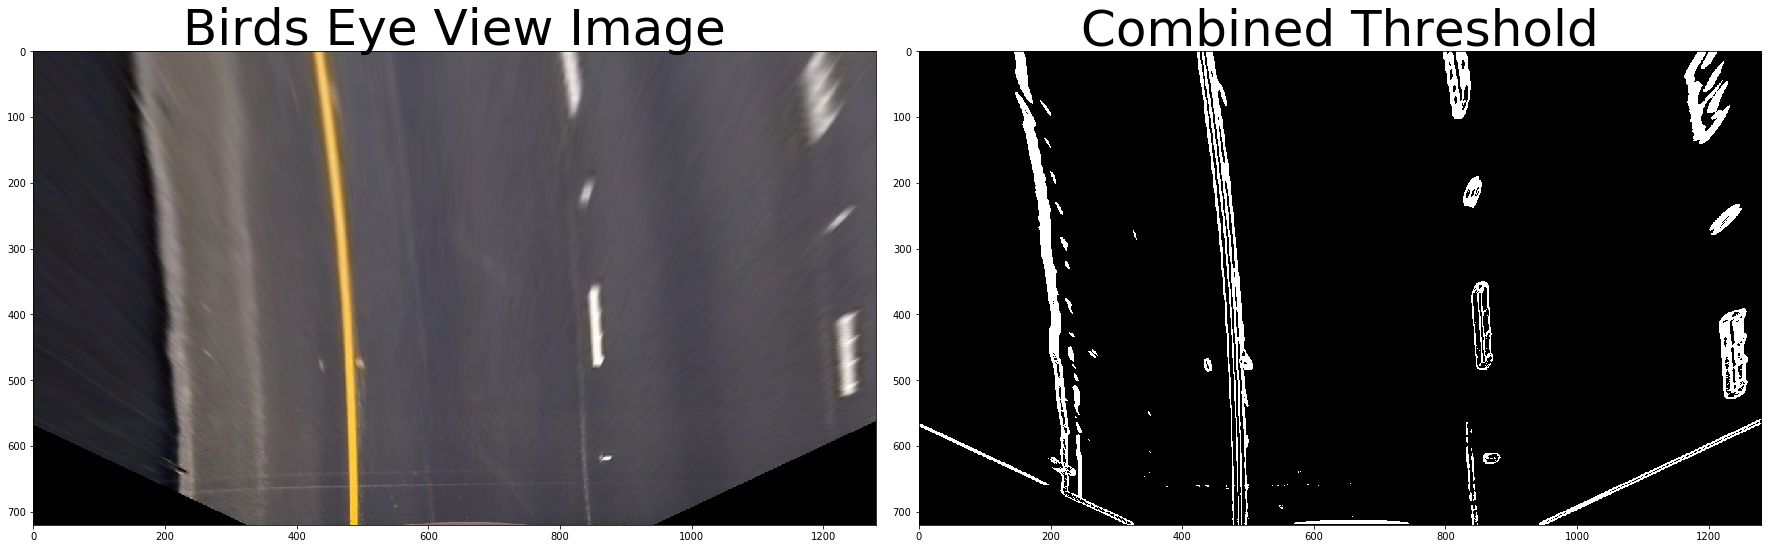

In [15]:
def combined_threshold(img):
    ksize = 21 # Choose a larger odd number to smooth gradient measurements
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_threshold(img, orient='x', threshold=(20,100))
    grady = abs_sobel_threshold(img, orient='y', threshold=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
   
    combined = np.zeros_like(mag_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1))] = 1
    
    return combined
    


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

undist_warpImg = cv2.imread('./output_images/warped_image1.jpg')
undist_warpImg = cv2.cvtColor(undist_warpImg, cv2.COLOR_BGR2RGB)
ax1.imshow(undist_warpImg)
ax1.set_title('Bird''s Eye View Image', fontsize=50)

combined_thresh = combined_threshold(undist_warpImg)

ax2.imshow(combined_thresh, cmap='gray')
ax2.set_title('Combined Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# HLS Color Spaces

In [70]:
def convert_gray_binary(img):
    thresh = (180, 255)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary



## Display Gray Image and Gray Binary Image

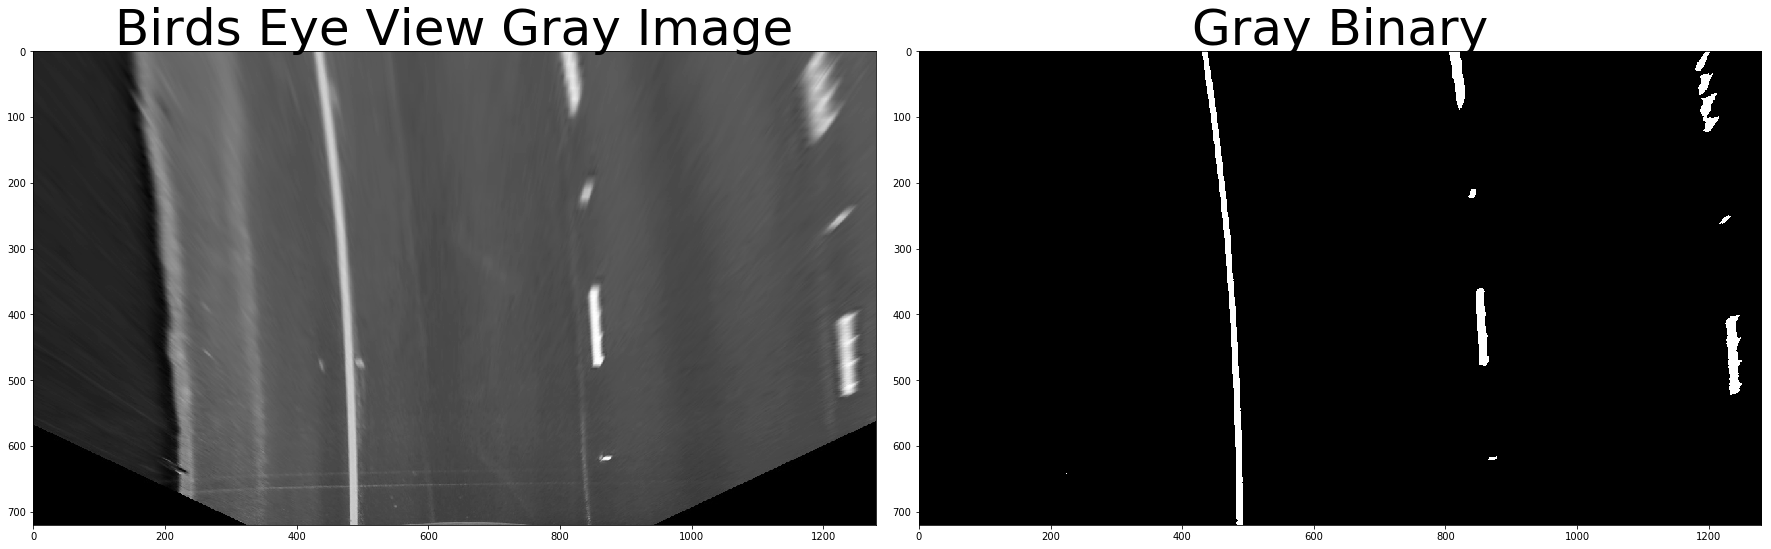

In [80]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

undist_warpImg = cv2.imread('./output_images/warped_image1.jpg')
undist_warpImg = cv2.cvtColor(undist_warpImg, cv2.COLOR_BGR2RGB)
undist_gray = cv2.cvtColor(undist_warpImg, cv2.COLOR_RGB2GRAY)
ax1.imshow(undist_gray, cmap='gray')
ax1.set_title('Bird''s Eye View Gray Image', fontsize=50)

gray_binary = convert_gray_binary(undist_warpImg)
ax2.imshow(gray_binary, cmap='gray')
ax2.set_title('Gray Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Convert the Image into RGB channels and corresponding RGB Binary Channels

In [91]:
def convert_to_R_binary(img):
    thresh = (200, 255)
    R_binary = np.zeros_like(img[:,:,0])
    R_binary[(img[:,:,0] > thresh[0]) & (img[:,:,0] <= thresh[1])] = 1
    return R_binary

In [92]:
def convert_to_G_binary(img):
    thresh = (200, 255)
    R_binary = np.zeros_like(img[:,:,1])
    R_binary[(img[:,:,1] > thresh[0]) & (img[:,:,1] <= thresh[1])] = 1
    return R_binary

In [93]:
def convert_to_B_binary(img):
    thresh = (200, 255)
    R_binary = np.zeros_like(img[:,:,2])
    R_binary[(img[:,:,2] > thresh[0]) & (img[:,:,0] <= thresh[1])] = 1
    return R_binary

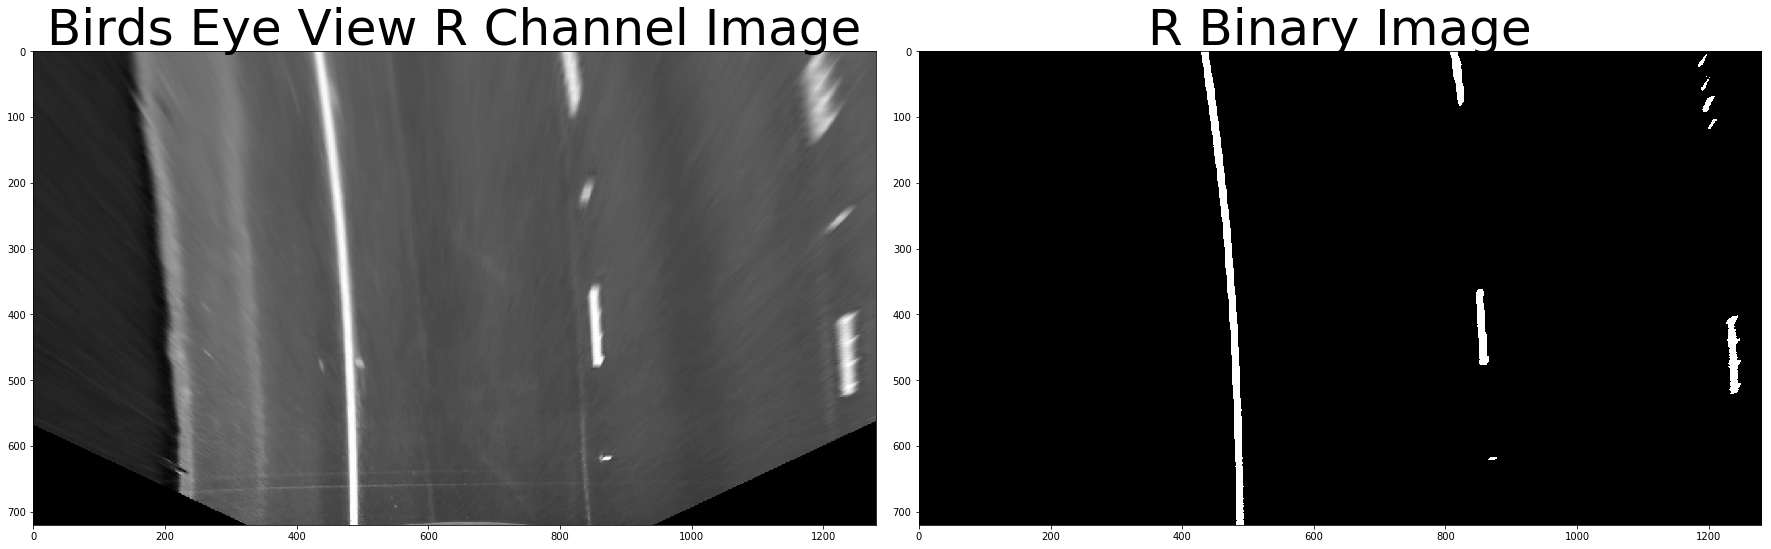

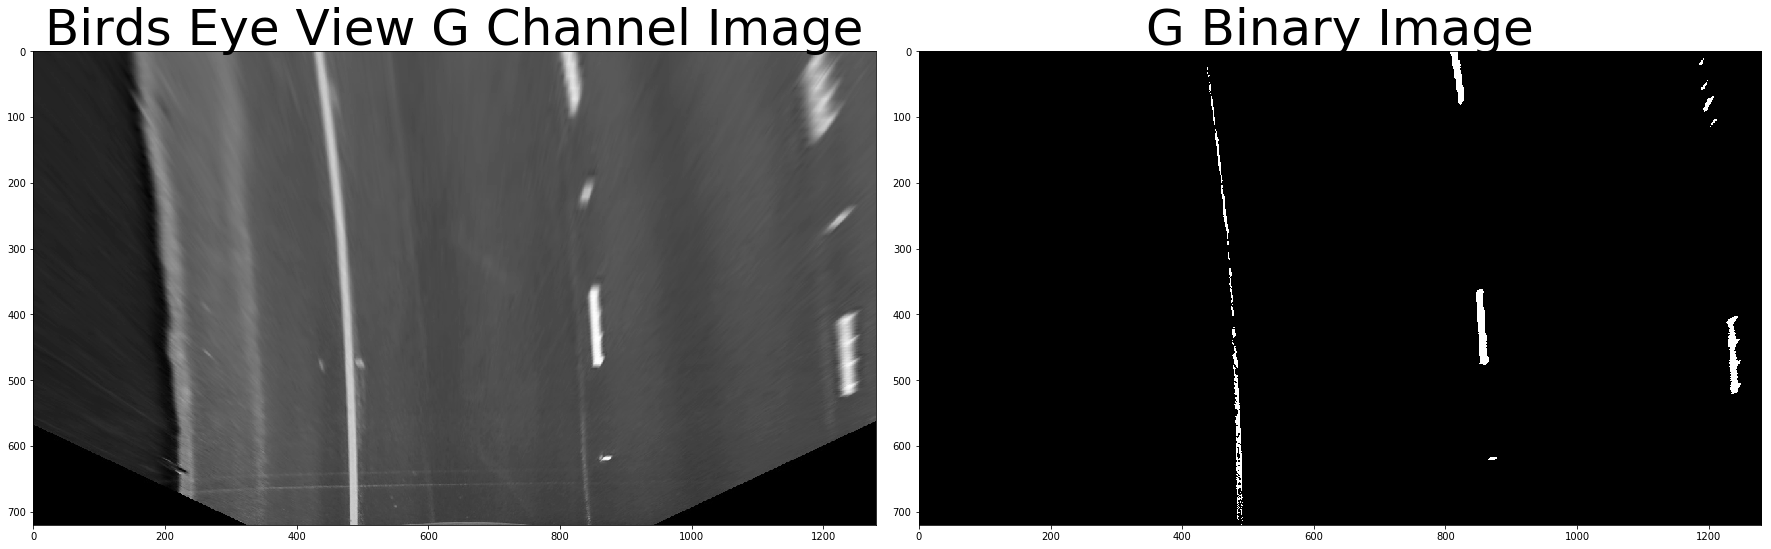

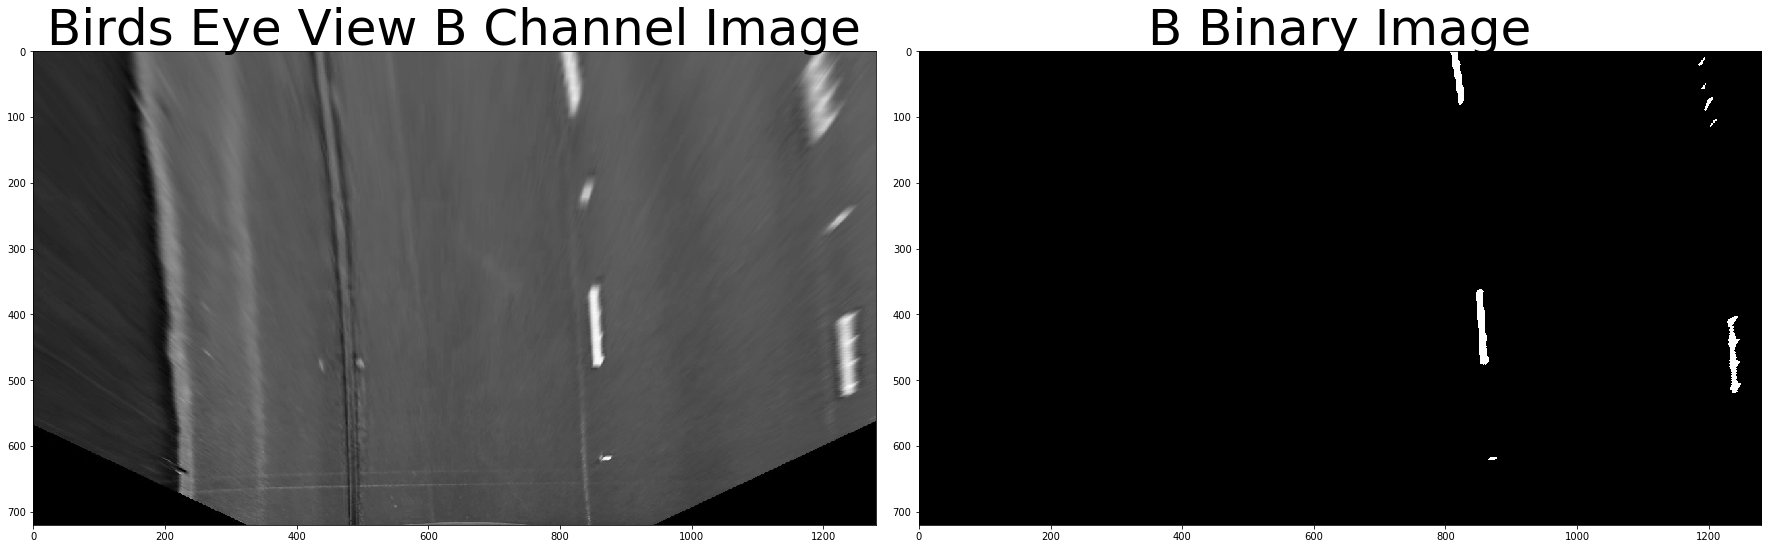

In [99]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

R_Img = cv2.imread('./output_images/warped_image1.jpg')
R_Img = cv2.cvtColor(R_Img, cv2.COLOR_BGR2RGB)
ax1.imshow(R_Img[:,:,0], cmap = 'gray')
ax1.set_title('Bird''s Eye View R Channel Image', fontsize=50)

R_Image = convert_to_R_binary(R_Img)
ax2.imshow(R_Image, cmap = 'gray')
ax2.set_title('R Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


f, (ax3, ax4) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

G_Img = cv2.imread('./output_images/warped_image1.jpg')
G_Img = cv2.cvtColor(G_Img, cv2.COLOR_BGR2RGB)
ax3.imshow(G_Img[:,:,1], cmap = 'gray')
ax3.set_title('Bird''s Eye View G Channel Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

G_bin_img = convert_to_G_binary(G_Img)
ax4.imshow(G_bin_img, cmap = 'gray')
ax4.set_title('G Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


f, (ax5, ax6) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

B_Img = cv2.imread('./output_images/warped_image1.jpg')
B_Img = cv2.cvtColor(B_Img, cv2.COLOR_BGR2RGB)
ax5.imshow(B_Img[:,:,2], cmap = 'gray')
ax5.set_title('Bird''s Eye View B Channel Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

B_bin_img = convert_to_B_binary(B_Img)
ax6.imshow(B_bin_img, cmap = 'gray')
ax6.set_title('B Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Convert the Image into HLS channels and corresponding HLS Binary Channels

In [109]:
def convert_to_H_binary(img):
    thresh = (15, 100)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H_binary = np.zeros_like(hls[:,:,0])
    H_binary[(hls[:,:,0] > thresh[0]) & (hls[:,:,0] <= thresh[1])] = 1
    return H_binary

def convert_to_L_binary(img):
    thresh = (90, 255)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_binary = np.zeros_like(hls[:,:,1])
    l_binary[(hls[:,:,1] > thresh[0]) & (hls[:,:,1] <= thresh[1])] = 1
    return l_binary

def convert_to_S_binary(img):    
    thresh = (90, 255)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_binary = np.zeros_like(hls[:,:,2])
    s_binary[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    return s_binary

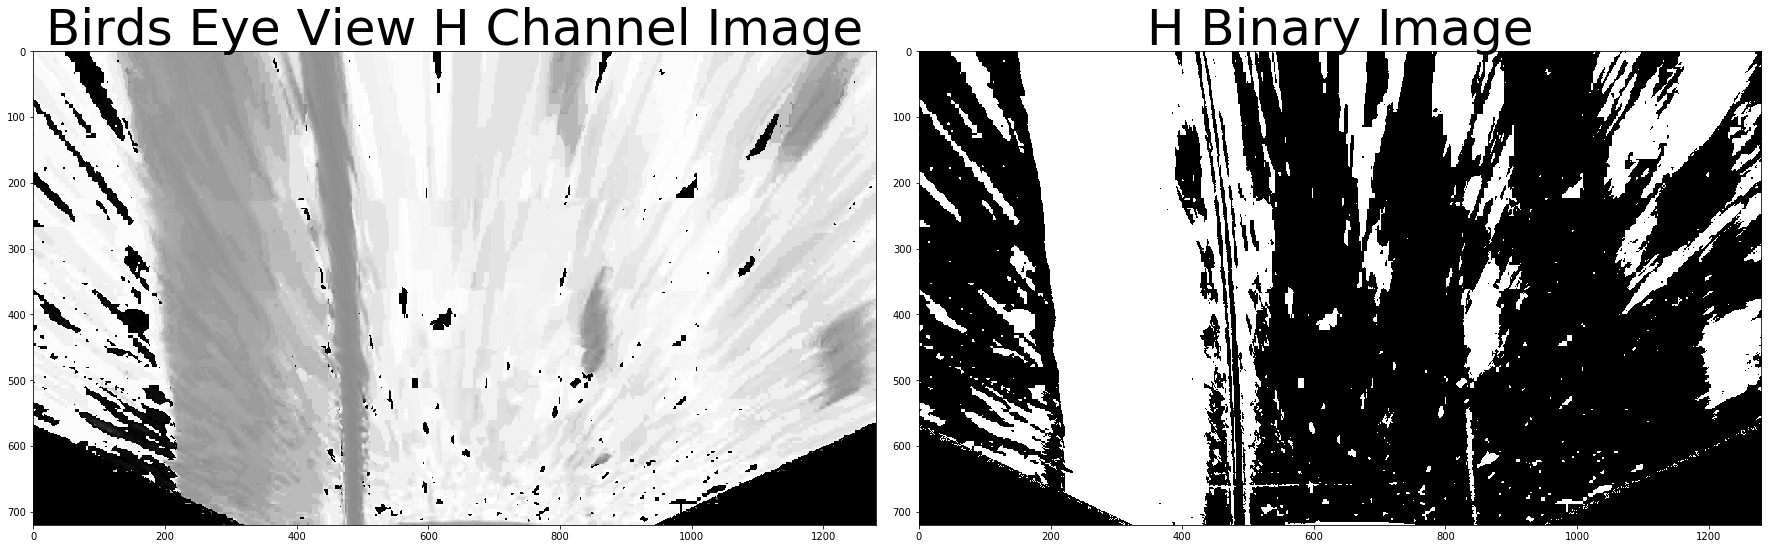

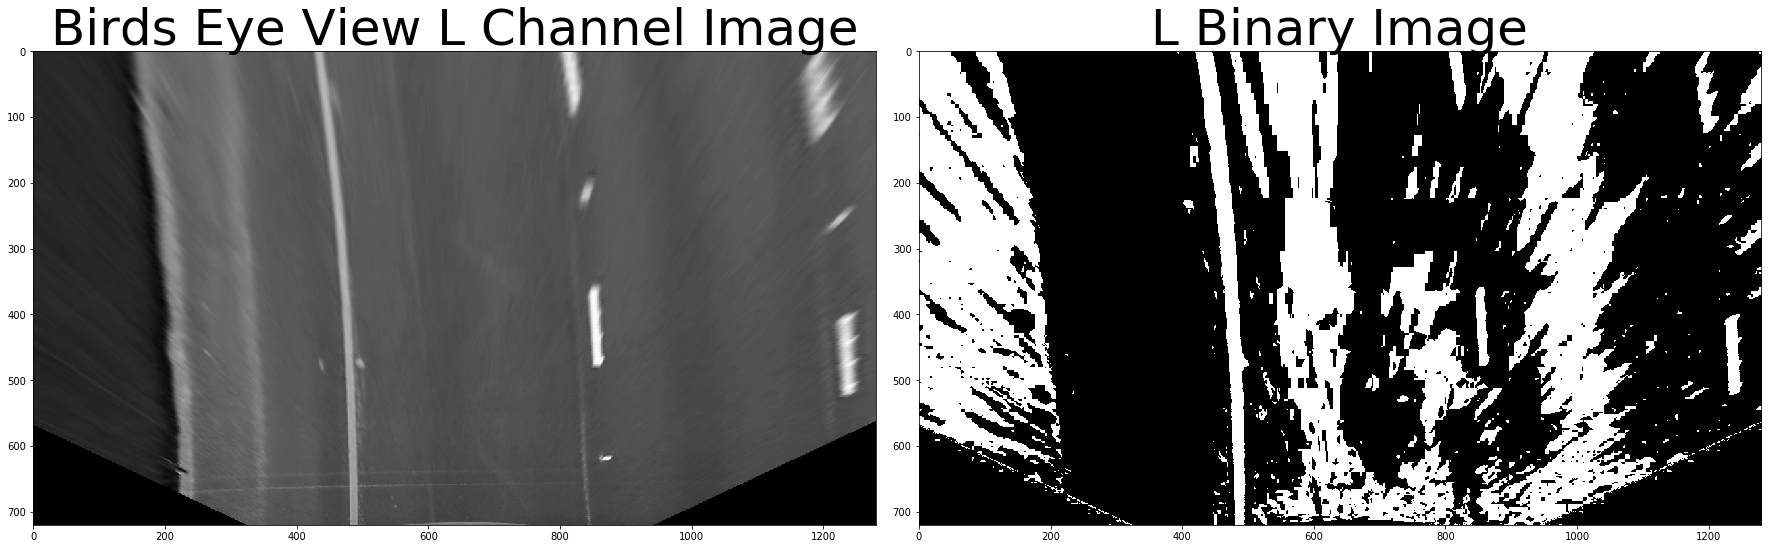

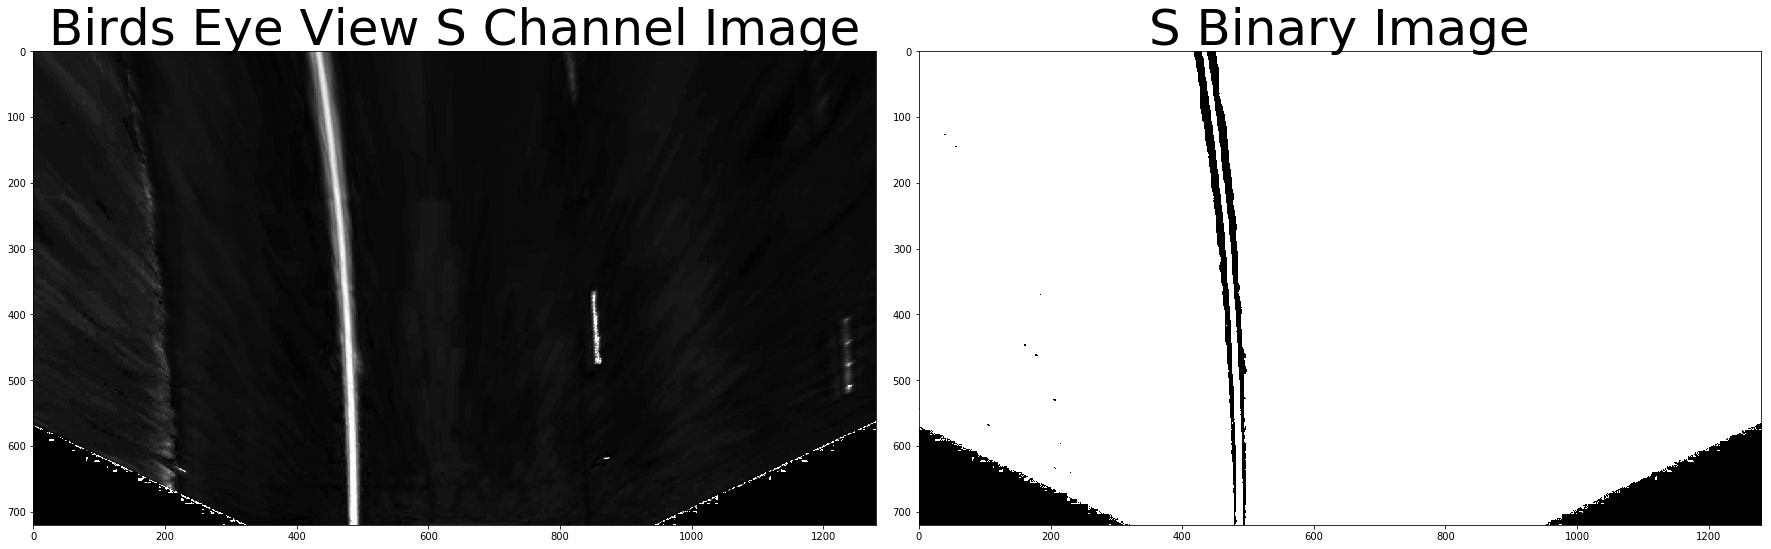

In [110]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

H_Img = cv2.imread('./output_images/warped_image1.jpg')
H_Img = cv2.cvtColor(H_Img, cv2.COLOR_RGB2HLS)
ax1.imshow(H_Img[:,:,0], cmap = 'gray')
ax1.set_title('Bird''s Eye View H Channel Image', fontsize=50)

H_bin_img = convert_to_H_binary(H_Img)
ax2.imshow(H_bin_img, cmap = 'gray')
ax2.set_title('H Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


f, (ax3, ax4) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

L_Img = cv2.imread('./output_images/warped_image1.jpg')
L_Img = cv2.cvtColor(L_Img, cv2.COLOR_RGB2HLS)
ax3.imshow(L_Img[:,:,1], cmap = 'gray')
ax3.set_title('Bird''s Eye View L Channel Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

L_bin_img = convert_to_L_binary(L_Img)
ax4.imshow(L_bin_img, cmap = 'gray')
ax4.set_title('L Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


f, (ax5, ax6) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

S_Img = cv2.imread('./output_images/warped_image1.jpg')
S_Img = cv2.cvtColor(S_Img, cv2.COLOR_RGB2HLS)
ax5.imshow(S_Img[:,:,2], cmap = 'gray')
ax5.set_title('Bird''s Eye View S Channel Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

S_bin_img = convert_to_S_binary(S_Img)
ax6.imshow(S_bin_img, cmap='gray')
ax6.set_title('S Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Define the full Pipeline

In [140]:
def image_pipeline(img):
    undist_img = undistort(img)
    warp_img, M, Minv = warp(undist_img, src, dst)
    thresh = (90, 255)
    hls = cv2.cvtColor(warp_img, cv2.COLOR_RGB2HLS)
    s_binary = np.zeros_like(hls[:,:,2])
    s_binary[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    
    B_thresh = (225, 255)
    gray = cv2.cvtColor(undist_warpImg, cv2.COLOR_RGB2GRAY)
    B_binary = np.zeros_like(warp_img[:,:,2])
    B_binary[(warp_img[:,:,2] > B_thresh[0]) & (warp_img[:,:,2] <= B_thresh[1])] = 1
    
    R_thresh = (200, 255)
    gray = cv2.cvtColor(undist_warpImg, cv2.COLOR_RGB2GRAY)
    R_binary = np.zeros_like(warp_img[:,:,0])
    R_binary[(warp_img[:,:,0] > R_thresh[0]) & (warp_img[:,:,0] <= R_thresh[1])] = 1
        
    combined = np.zeros_like(s_binary)
    #combined[(s_binary == 1) & (B_binary == 1) | (R_binary == 1) ] = 1
    combined[(s_binary == 1) & (R_binary == 1) ] = 1
    return combined, Minv

# Run the pipeline

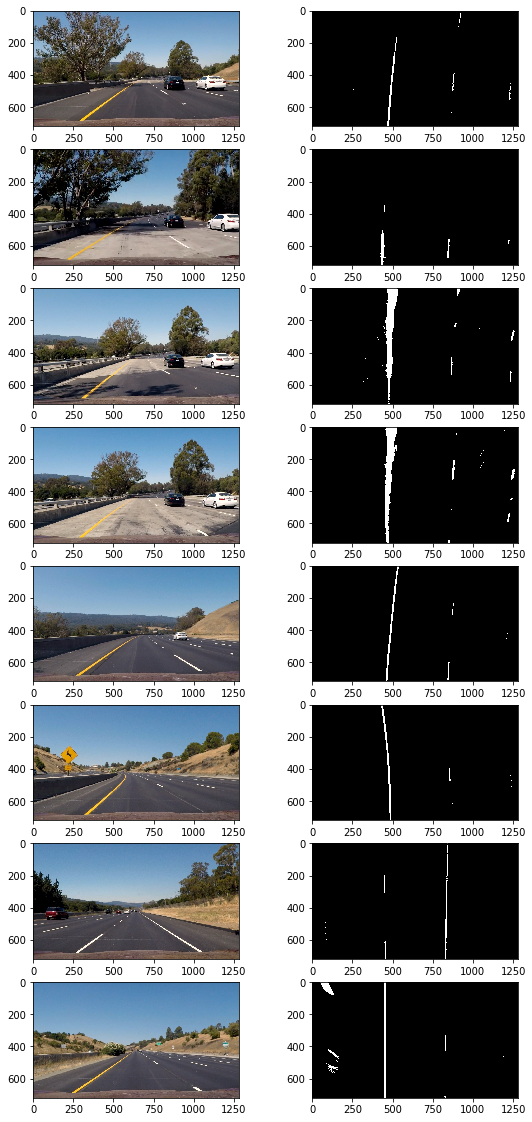

In [154]:
images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = image_pipeline(img)
    
    axs[i].imshow(img)
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    i += 1

## Implement Sliding Windows and Fit a Polynomial

#### With the histogram I am adding up the pixel values along each column in the image. In my thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. I can use that as a starting point for where to search for the lines. From that point, I can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.


In [155]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data


(720, 0)

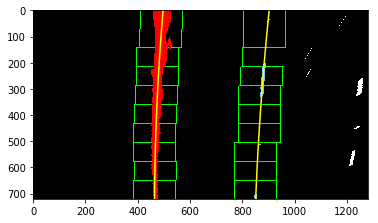

In [156]:

exampleImg = cv2.imread('./test_images/test1.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin, Minv = image_pipeline(exampleImg)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [157]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

### Skip the sliding windows once you know where the lines are and just search in a margin around the previous line position

### The green shaded area shows where we searched for the lines this time. So, once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame. This is equivalent to using a customized region of interest for each frame of video, and should help you track the lanes through sharp curves and tricky conditions. If you lose track of the lines, go back to your sliding windows search or other method to rediscover them.

...


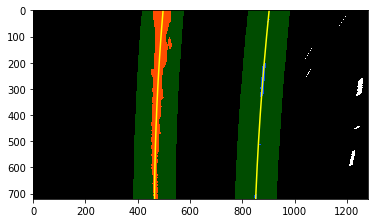

In [158]:
# visualize the result on example image
exampleImg2 = cv2.imread('./test_images/test1.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin, Minv = image_pipeline(exampleImg2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print('...')

# Radius of Curvature and Distance from Lane Center Calculation

### We have a thresholded image, where I have estimated which pixels belong to the left and right lane lines and fit a polynomial to those pixel positions. Next we'll compute the radius of curvature of the fit.


In [159]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist


In [160]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 883.477178682 m, 1083.1301207 m
Distance from lane center for example: -0.172717230822 m


In [161]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

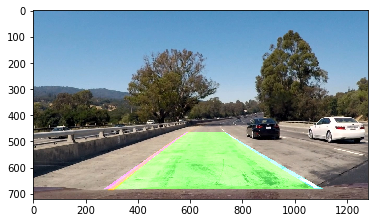

In [162]:
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)

In [163]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

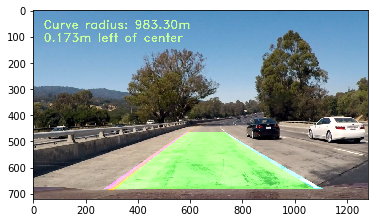

In [164]:
exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out2)

In [165]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

In [166]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = image_pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out

In [167]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img

In [168]:
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
l_line = Line()
r_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:42<00:00,  7.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 42s, sys: 14.1 s, total: 4min 56s
Wall time: 2min 44s
